In [2]:
suppressMessages({
library(Seurat)
library(tidyverse)
library(ggpubr)
dotenv::load_dot_env()
Sys.setenv("PATH" = paste0(Sys.getenv("PATH"), ":", Sys.getenv("FAST_TSNE_BIN")))
})

In [ ]:
FGID13 = readRDS(Sys.getenv("FG13srobj"))
FGmeta = read.table(Sys.getenv("FG13metafile"), sep="\t", header=1)
rownames(FGmeta) = FGmeta$CellID
FGID13@meta.data = cbind(FGID13@meta.data, FGmeta[colnames(FGID13),])

In [12]:
FGID13

An object of class Seurat 
44291 features across 115569 samples within 2 assays 
Active assay: SCT (21591 features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, tsne

# Tsnes celltypes

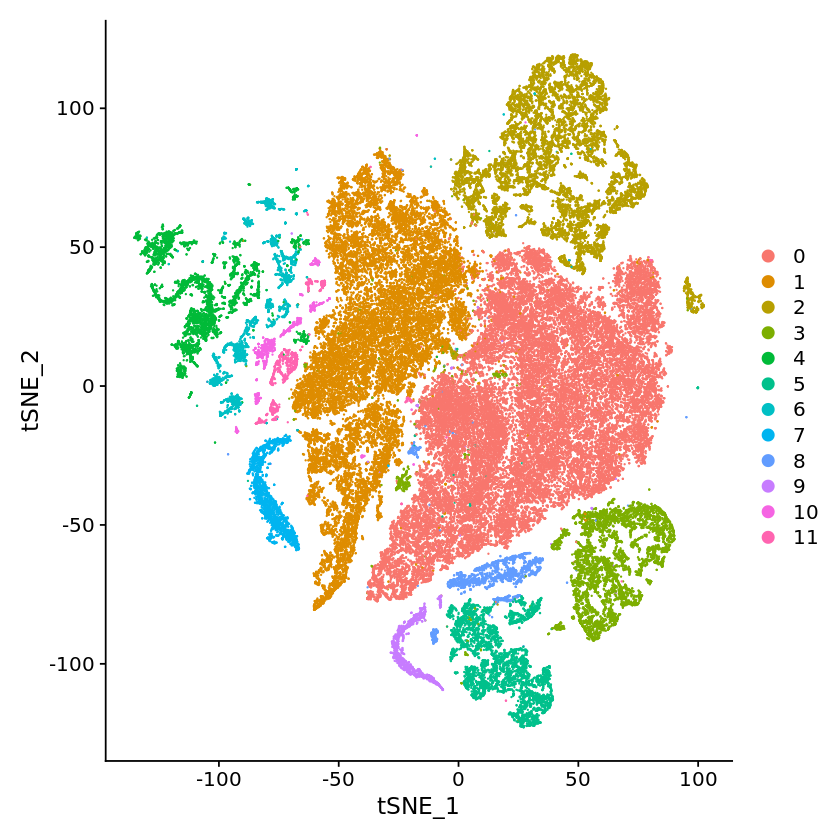

In [52]:
DimPlot(FGID13)

In [4]:
FIGDIR=file.path(Sys.getenv("FIGDIR"), "fg13atlas", "tsne")
dir.create(FIGDIR, recursive = TRUE, showWarnings = FALSE)

In [3]:
celltype_colors = c(Bclls = '#1F77B4', Endth = '#FF9B45', Epith = '#3BA63B',
                Fibro = '#D62728', Glial = '#A07AC4', IGA_IGK_Plsma= '#7F7F7F',
                IGA_IGL_Plsma = '#7F7F7F', IGG_Plsma_Bcll= '#3F3F3F', IGM_Plsma='#BFBFBF',
                Mloid = '#8C564B', Mstcl = '#E586C8', Tclls = '#1ABECF')

In [ ]:
srobj =  FGID13[, !grepl("Doub|LowQual", FGID13$type)]

In [56]:
srobj

An object of class Seurat 
44291 features across 99488 samples within 2 assays 
Active assay: SCT (21591 features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, tsne

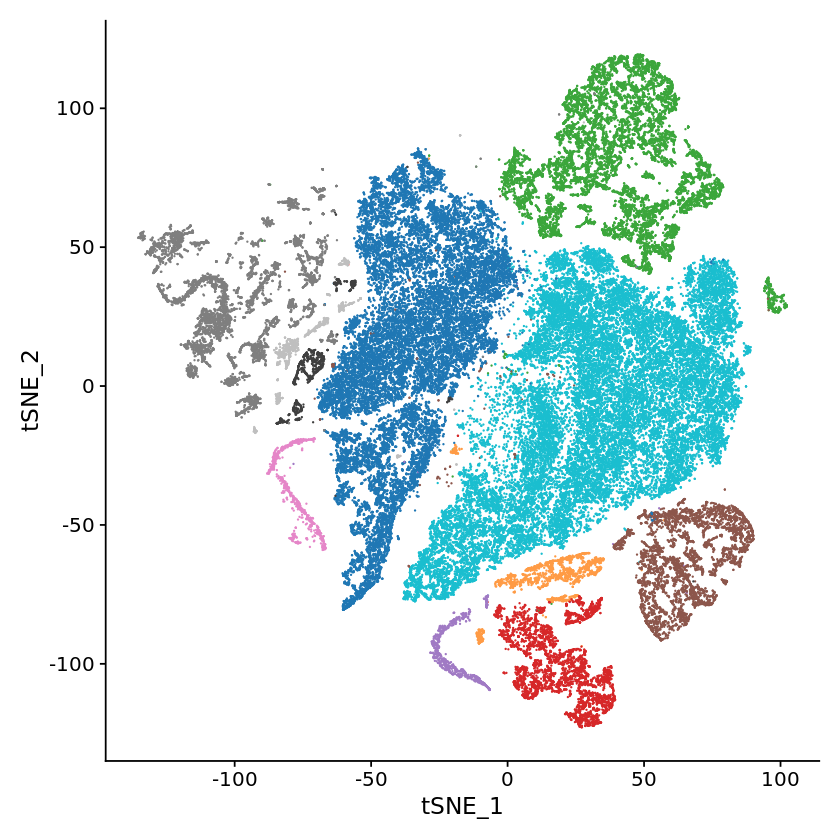

In [57]:
p = DimPlot(srobj, group.by="celltypes", cols=celltype_colors)
p + NoLegend()

In [58]:
srobj <- RunTSNE(srobj, 
                 initialization = srobj@reductions$pca@cell.embeddings[, 1:2],
                 perplexity_list = c(30, ncol(srobj)/100),
                 learning_rate = ncol(srobj)/12,
                 exaggeration = 12,
                 dims = 1:22,
                 tsne.method = "FIt-SNE")

Warning message:
“The following arguments are not used: pca”


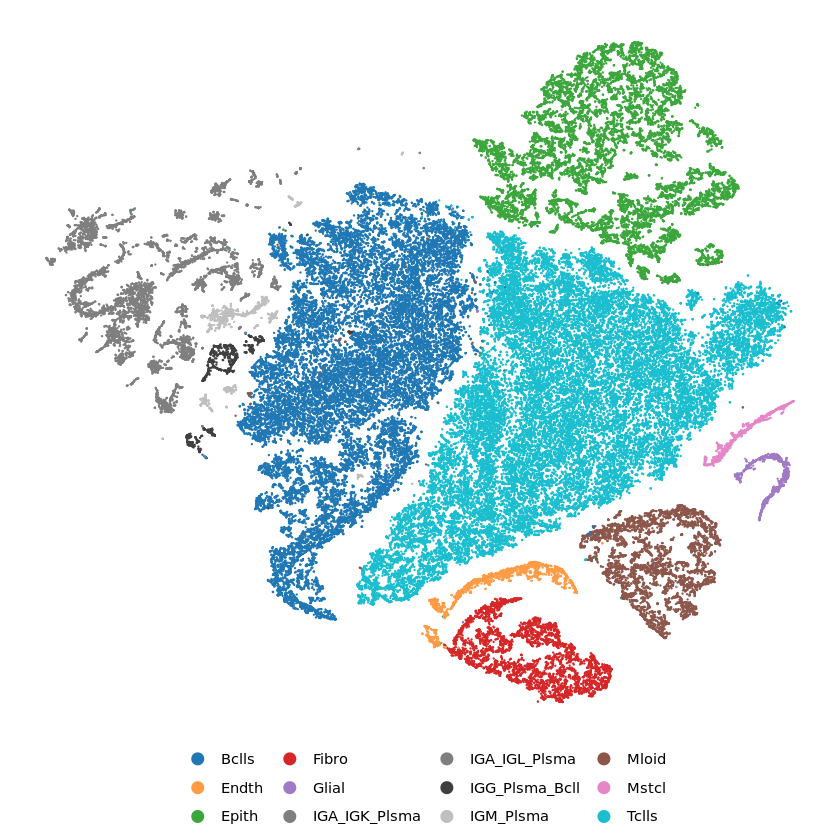

In [59]:
p = DimPlot(srobj, group.by="celltypes", cols=celltype_colors) +
    theme_void() +
    theme(legend.position="bottom")
p

In [60]:
L = get_legend(p)
# p + NoLegend()
# as_ggplot(L)
ggsave(plot = p + NoLegend(), 
       file=file.path(FIGDIR, "20200402allFGID_celltypes_tsne_points.pdf"),
       height=8,
       width=8,
       useDingbats=FALSE)
ggsave(plot = as_ggplot(L),
       file=file.path(FIGDIR, "20200402allFGID_celltypes_tsne_legend.pdf"),
       useDingbats=FALSE)

Saving 6.67 x 6.67 in image



# Tsnes patient

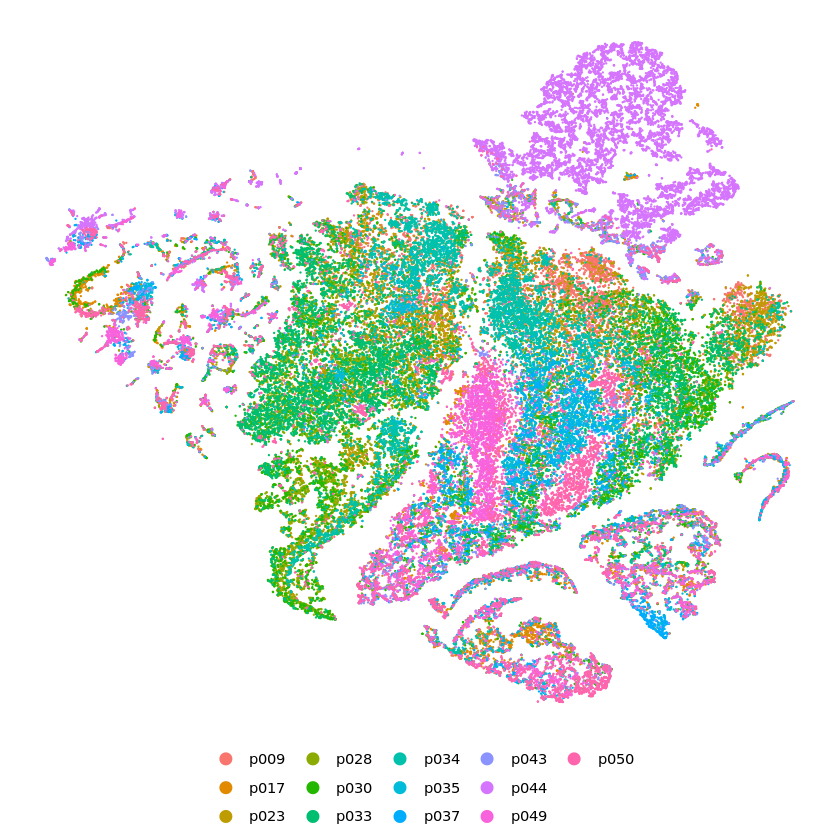

In [61]:
p = DimPlot(srobj, group.by="patient") +
    theme_void() +
    theme(legend.position="bottom")
p

In [62]:
L = get_legend(p)
# p + NoLegend()
# as_ggplot(L)
ggsave(plot = p + NoLegend(), 
       file=file.path(FIGDIR, "20200402allFGID_patient_tsne_points.pdf"),
       height=8,
       width=8,
       useDingbats=FALSE)
ggsave(plot = as_ggplot(L),
       file=file.path(FIGDIR, "20200402allFGID_patient_tsne_legend.pdf"),
       useDingbats=FALSE)

Saving 6.67 x 6.67 in image



In [63]:
levels(srobj$patient)

[1] "p009" "p017" "p023" "p028" "p030" "p033" "p034" "p035" "p037" "p043"
[11] "p044" "p049" "p050"

In [64]:
plist = lapply(levels(srobj$patient), function(id){
    p = DimPlot(srobj[, srobj$patient == id],
                group.by="celltypes", 
                cols=celltype_colors) +
    theme_void() +
#     theme(legend.position="bottom", 
#           axis.ticks.x = element_blank(),
#           axis.ticks.y = element_blank(),
#           axis.text.x = element_blank(),
#           axis.text.y = element_blank(),
#           ) + 
#     labs(x = "", y = "") +
    ggtitle(id) +
    NoLegend()
    return(p)
})


# ppoints = lapply(plist, function(p) {p + NoLegend() + })

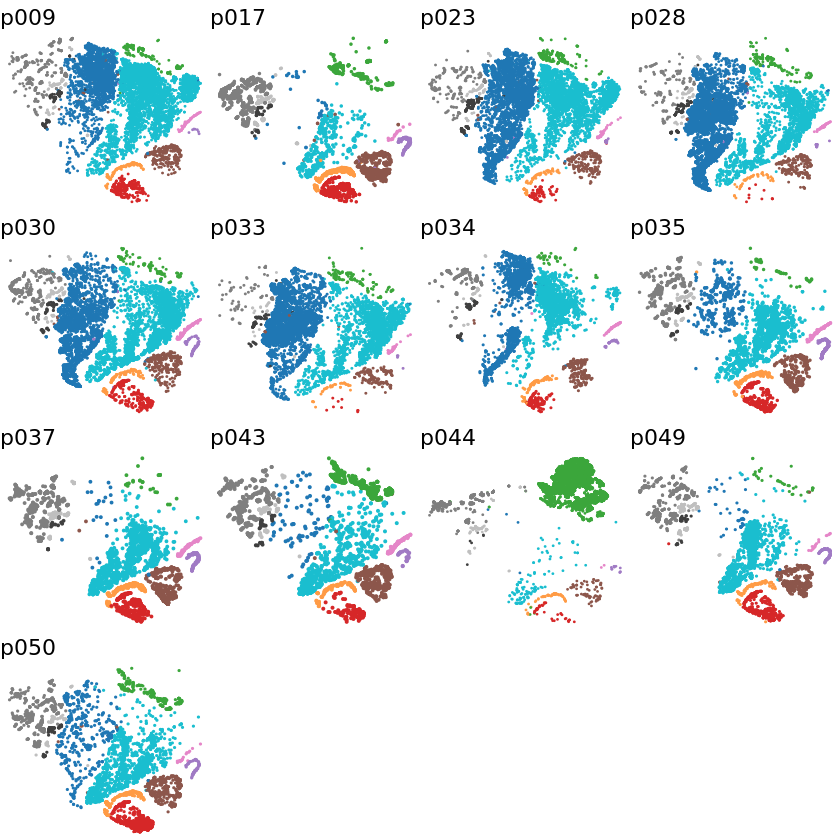

In [65]:
suppressMessages(library(gridExtra))
grid.arrange(grobs=plist, ncol=4)

In [66]:
ggsave(plot = arrangeGrob(grobs=plist, ncol=4), 
       file=file.path(FIGDIR, "20200402allFGID_separatepatient_tsne_points.pdf"),
       height=8,
       width=8,
       useDingbats=FALSE)

# dotplot marker genes

In [3]:
levels(srobj$celltypes)

[1] "Bclls"          "Endth"          "Epith"          "Fibro"         
 [5] "Glial"          "IGA_IGK_Plsma"  "IGA_IGL_Plsma"  "IGG_Plsma_Bcll"
 [9] "IGM_Plsma"      "Mloid"          "Mstcl"          "Tclls"

In [4]:
Idents(srobj) = factor(srobj$celltypes,levels(srobj$celltypes)[c(3, 12, 10, 1, 6:9, 11, 2, 4, 5)])
markers = FindAllMarkers(srobj, assay="RNA",
               test.use="wilcox", 
               logfc.threshold = 0.25,
               min.pct = 0.1,
               only.pos = TRUE, 
               max.cells.per.ident = 5000)

Calculating cluster Epith

Calculating cluster Tclls

Calculating cluster Mloid

Calculating cluster Bclls

Calculating cluster IGA_IGK_Plsma

Calculating cluster IGA_IGL_Plsma

Calculating cluster IGG_Plsma_Bcll

Calculating cluster IGM_Plsma

Calculating cluster Mstcl

Calculating cluster Endth

Calculating cluster Fibro

Calculating cluster Glial



In [5]:
genes.use = markers %>% group_by(cluster) %>%  top_n(2, wt=avg_logFC)

In [6]:
srobj = ScaleData(srobj, features=genes.use$gene)

Centering and scaling data matrix



In [7]:
cells.use = srobj@meta.data %>% group_by(celltypes) %>% sample_n(100) %>% .$cellname %>% as.character

In [8]:
srobj

An object of class Seurat 
44291 features across 99488 samples within 2 assays 
Active assay: SCT (21591 features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, tsne

In [9]:
p = DotPlot(srobj,
            features=genes.use$gene,
#           size=2,
#           cells=cells.use, 
#           group.colors = celltype_colors[levels(Idents(srobj))],
#           raster=FALSE,
#           label=TRUE
)

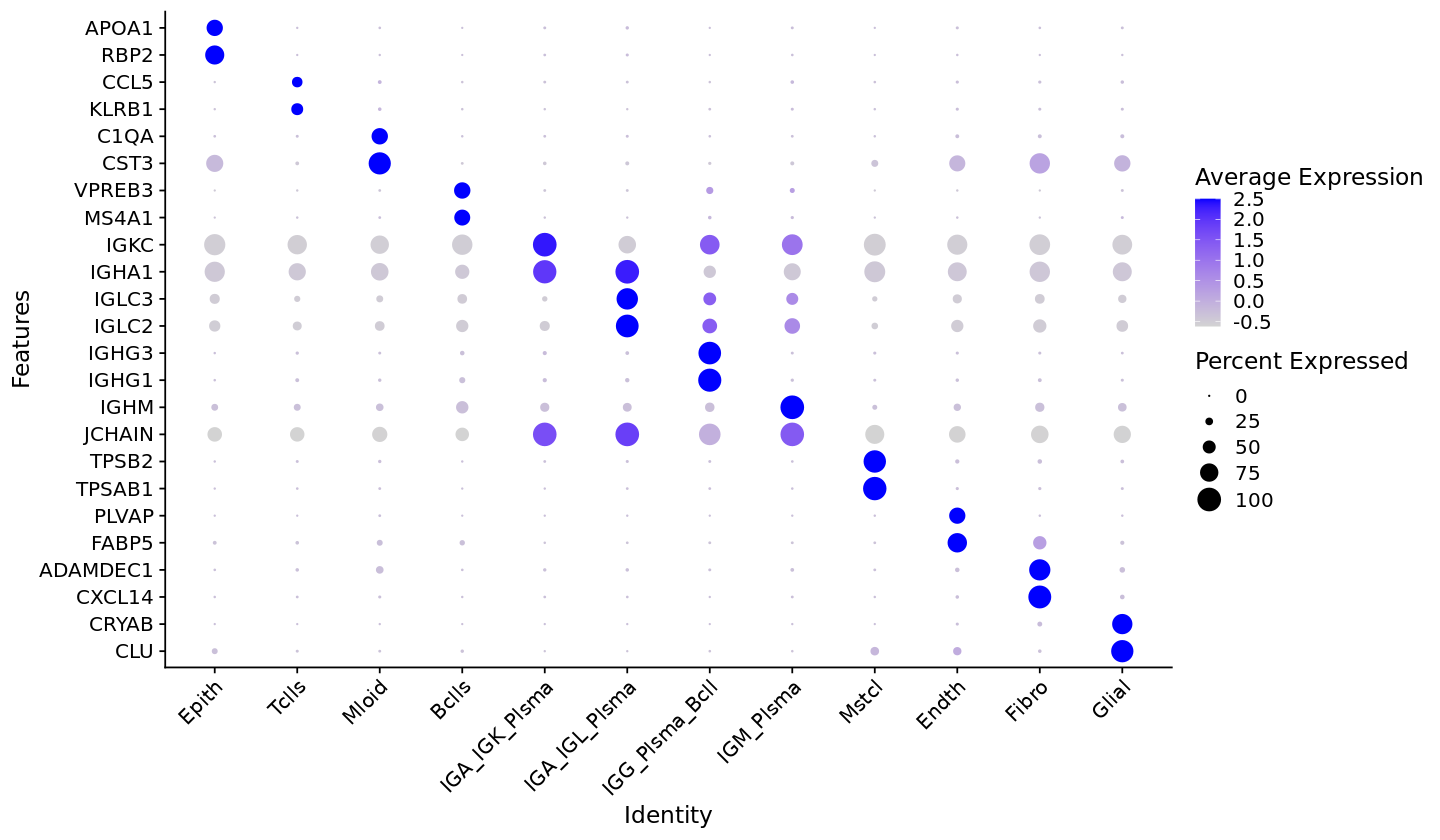

In [10]:
options(repr.plot.width = 12, repr.plot.height = 7)
p + theme(axis.text.x = element_text(angle=45, hjust=1)) + coord_flip()

In [53]:
FIGDIR=file.path(Sys.getenv("FIGDIR"), "fg13atlas", "dotplot")
dir.create(FIGDIR, recursive = TRUE, showWarnings = FALSE)

In [11]:
ggsave(plot=p + theme(axis.text.x = element_text(angle=45, hjust=1)) + coord_flip(),
       file=file.path(FIGDIR, "20200408alldata_markergenes_dotplot.pdf"),
       height=7, width=12,
       useDingbats=FALSE)

# Cell subset tsnes

In [68]:
levels(srobj$celltypes)

[1] "Bclls"          "Endth"          "Epith"          "Fibro"         
 [5] "Glial"          "IGA_IGK_Plsma"  "IGA_IGL_Plsma"  "IGG_Plsma_Bcll"
 [9] "IGM_Plsma"      "Mloid"          "Mstcl"          "Tclls"

In [96]:
nodoublet_dir = "~/FGID13/srobjs_doubletsremoved"
dir.create(nodoublet_dir, recursive = TRUE, showWarnings = FALSE)

In [80]:
filename = Sys.glob("~/FGID13/T1*")[1]

In [39]:
FIGDIR=file.path(Sys.getenv("FIGDIR"), "fg13atlas", "subset_tsnes")
dir.create(FIGDIR, recursive = TRUE, showWarnings = FALSE)

[1] "Bclls"
[1] "Endth"


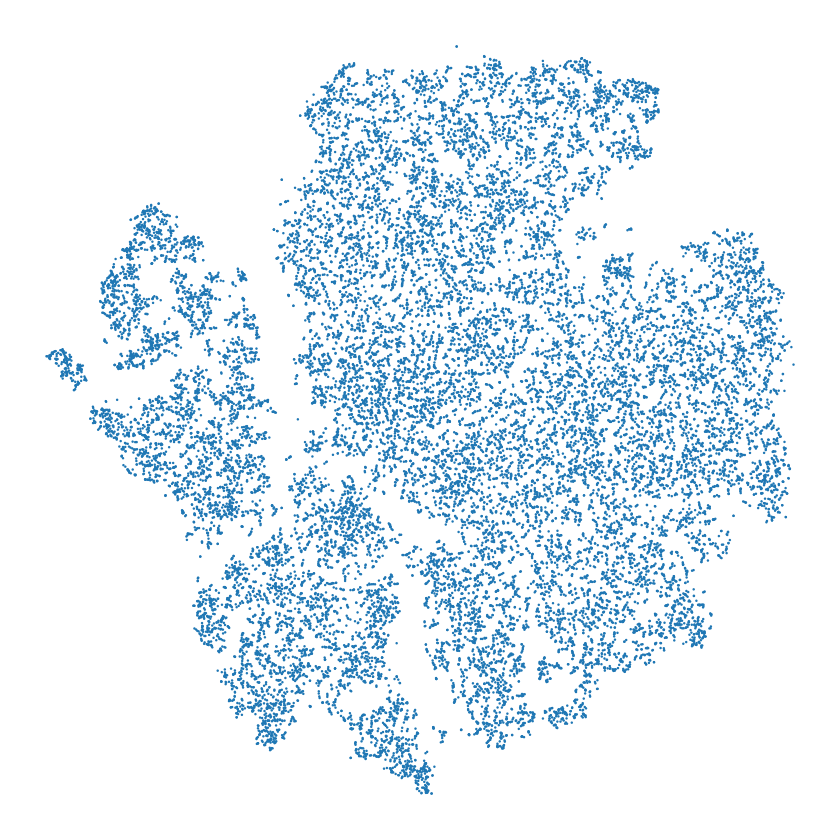

[1] "Epith"


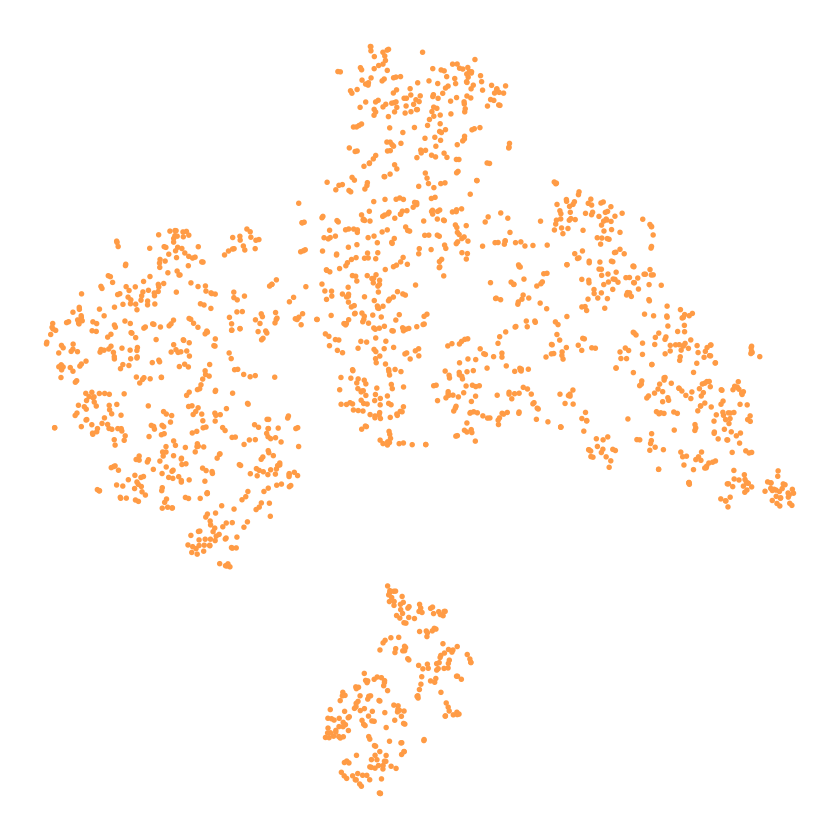

[1] "Fibro"


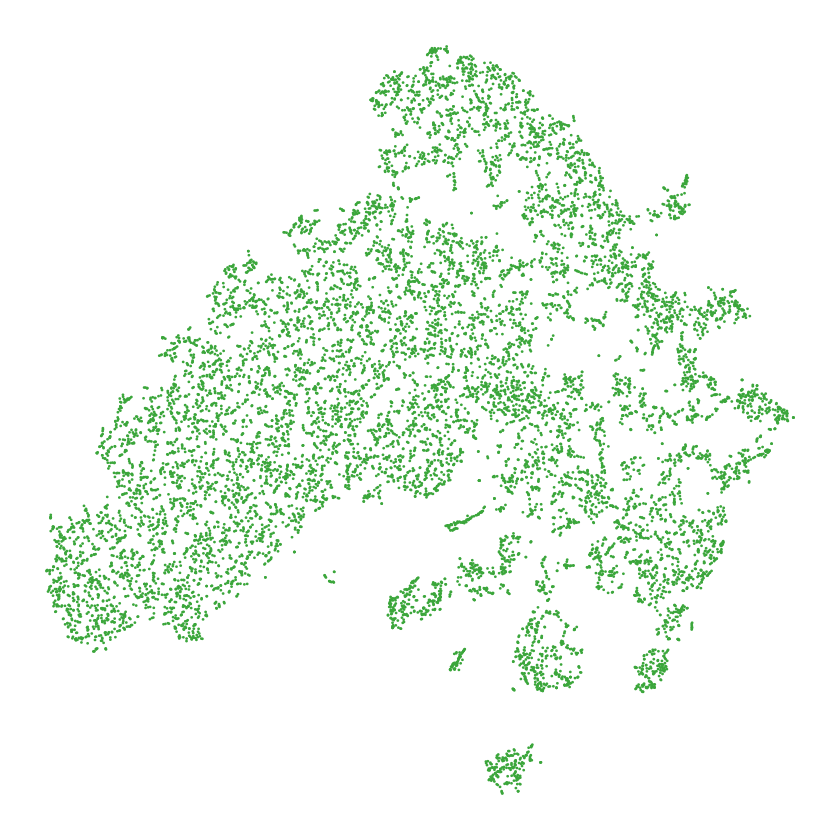

[1] "Glial"


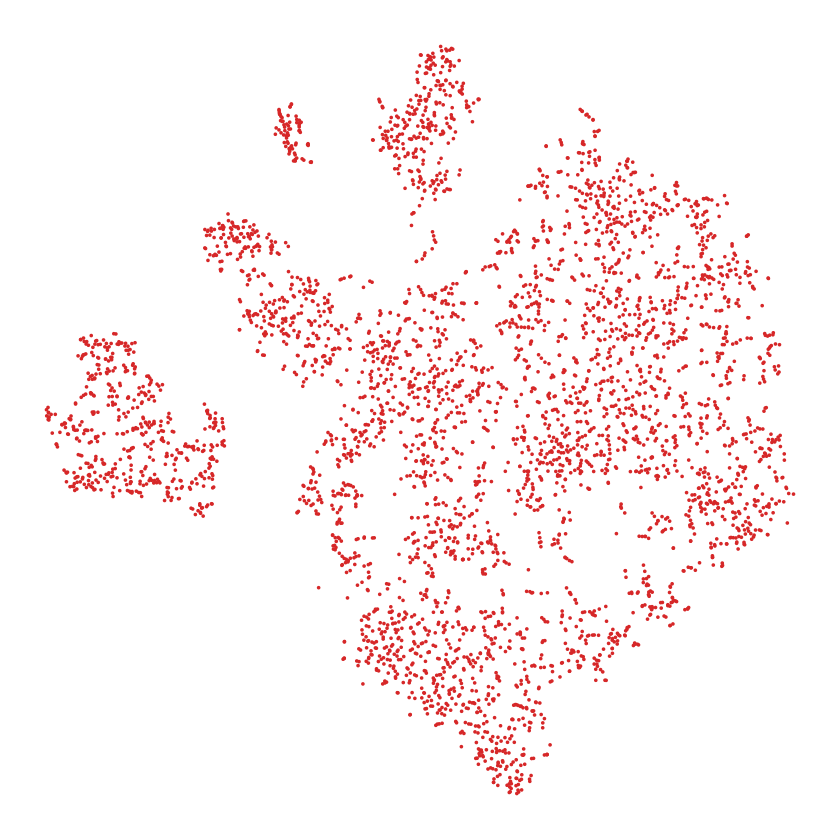

[1] "IGA_IGK_Plsma"


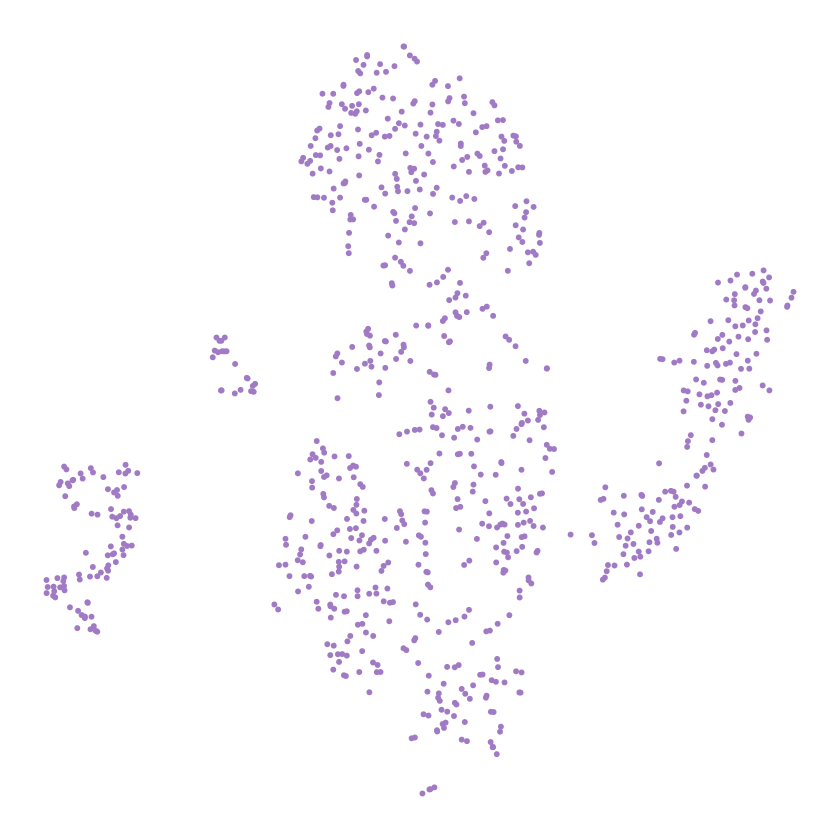

[1] "IGA_IGL_Plsma"


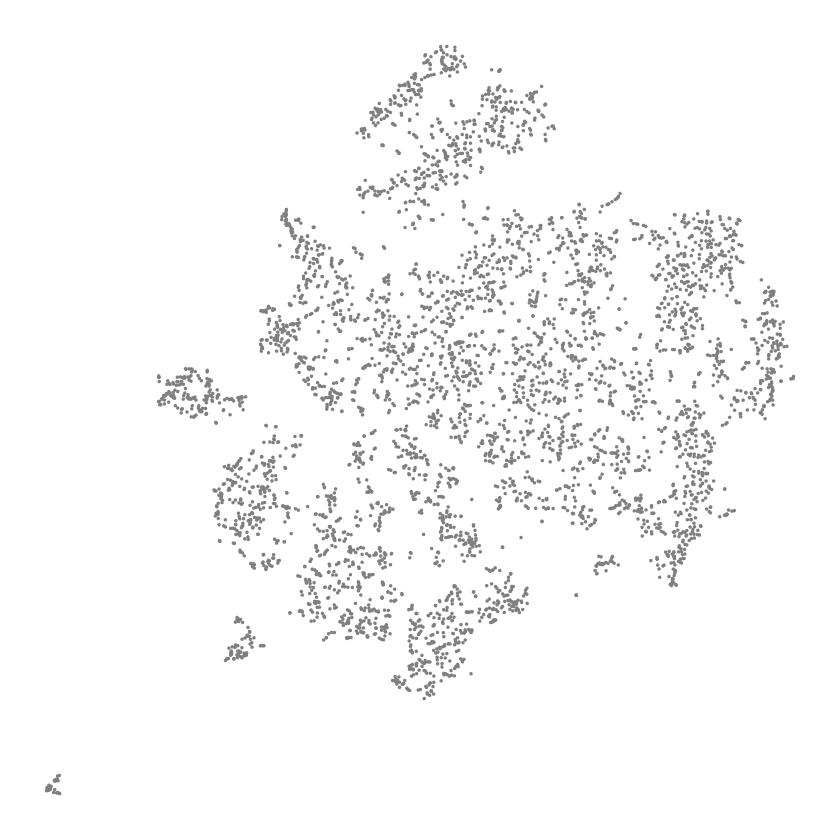

[1] "IGG_Plsma_Bcll"


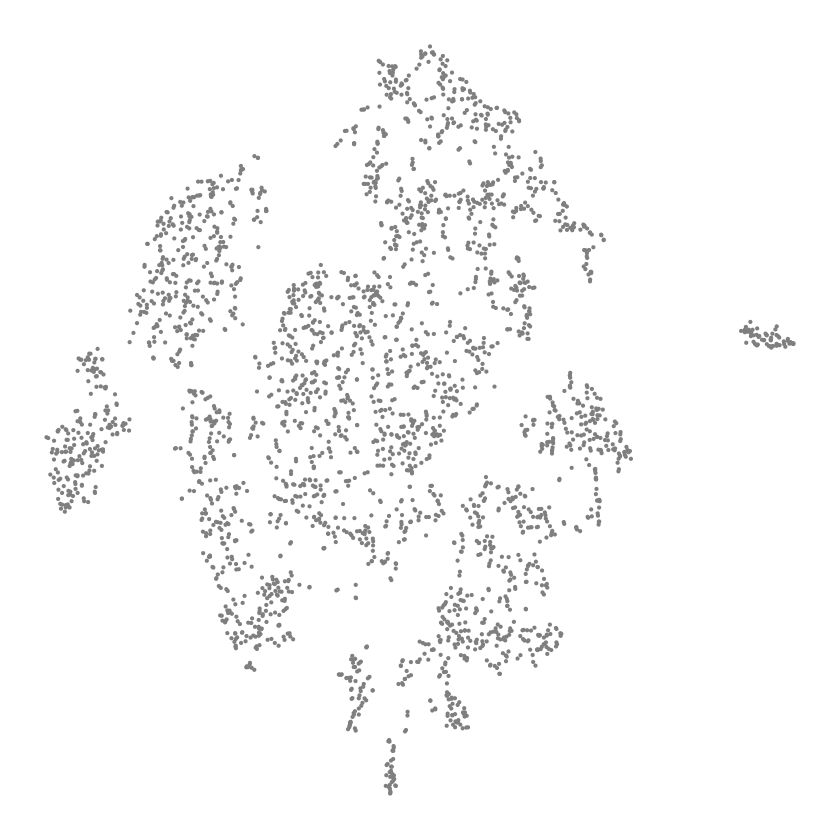

[1] "IGM_Plsma"


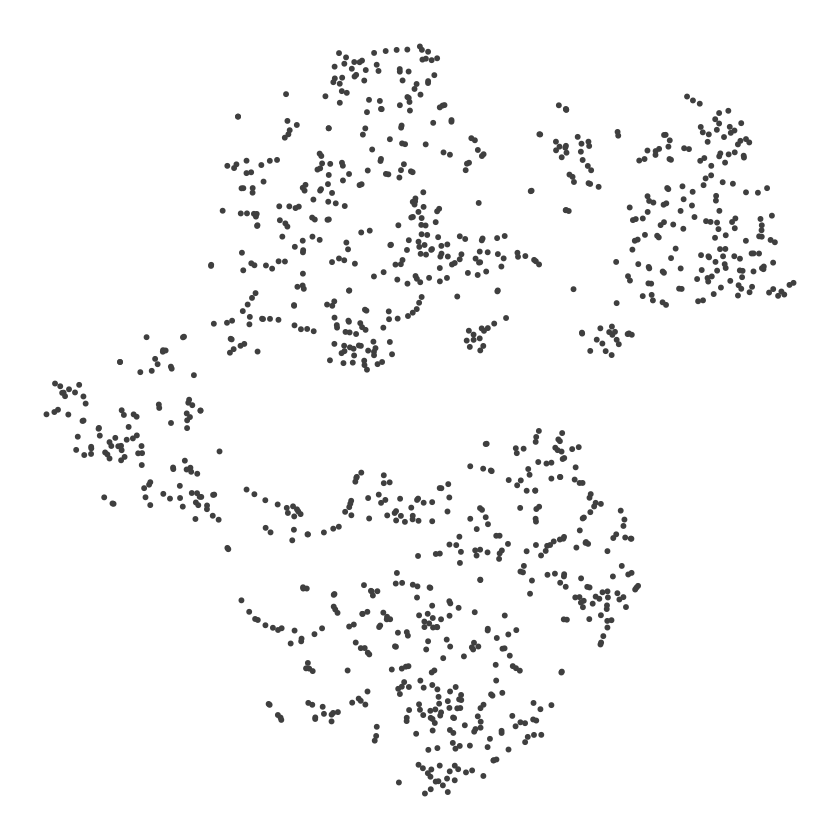

[1] "Mloid"


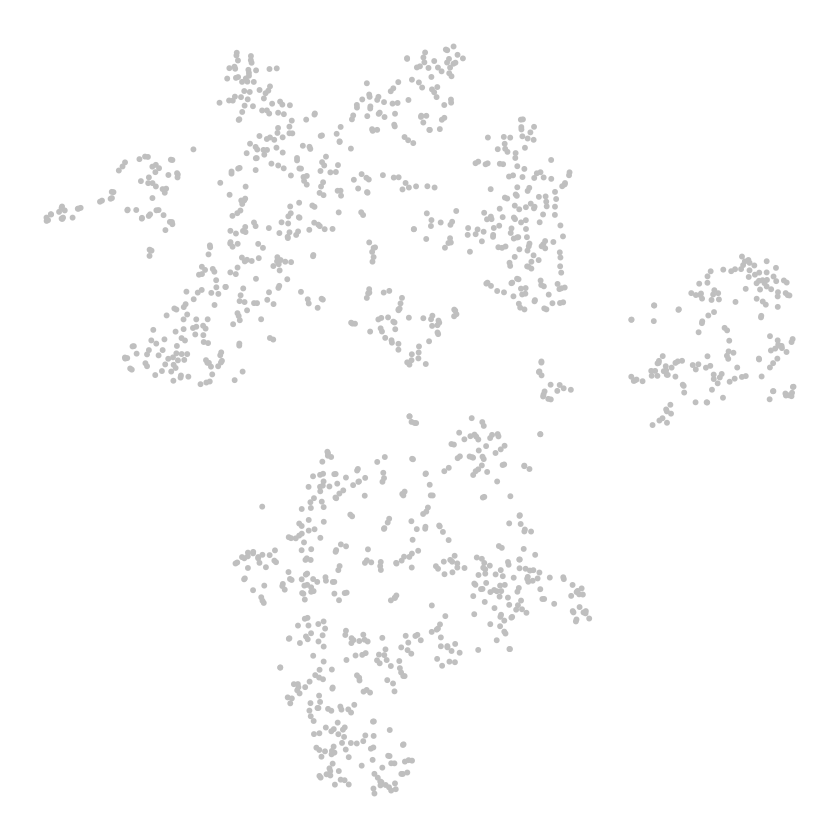

[1] "Mstcl"


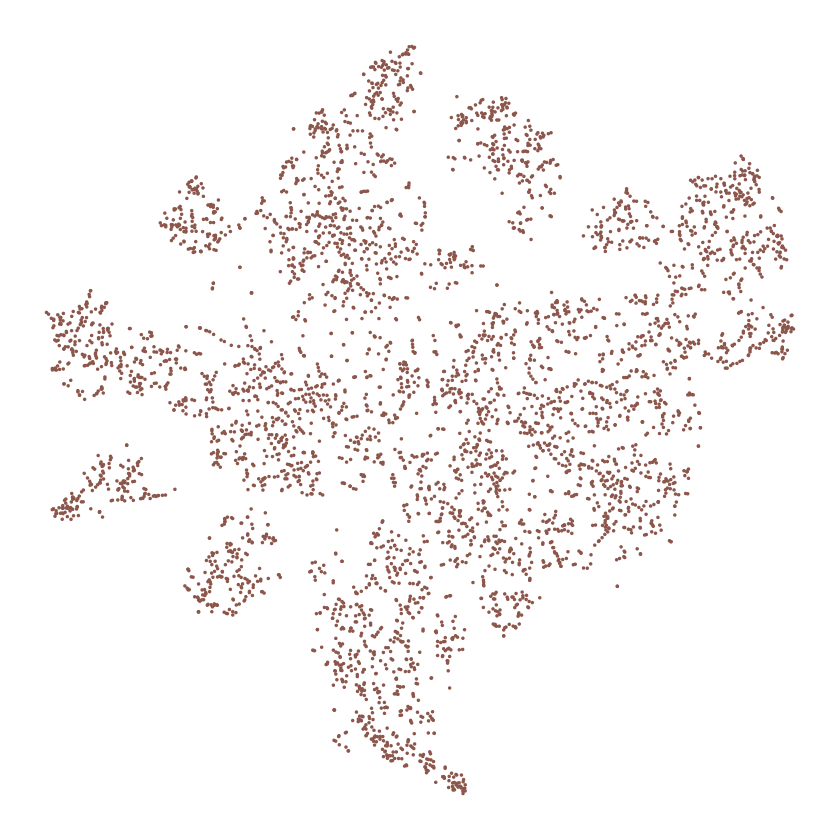

[1] "Tclls"


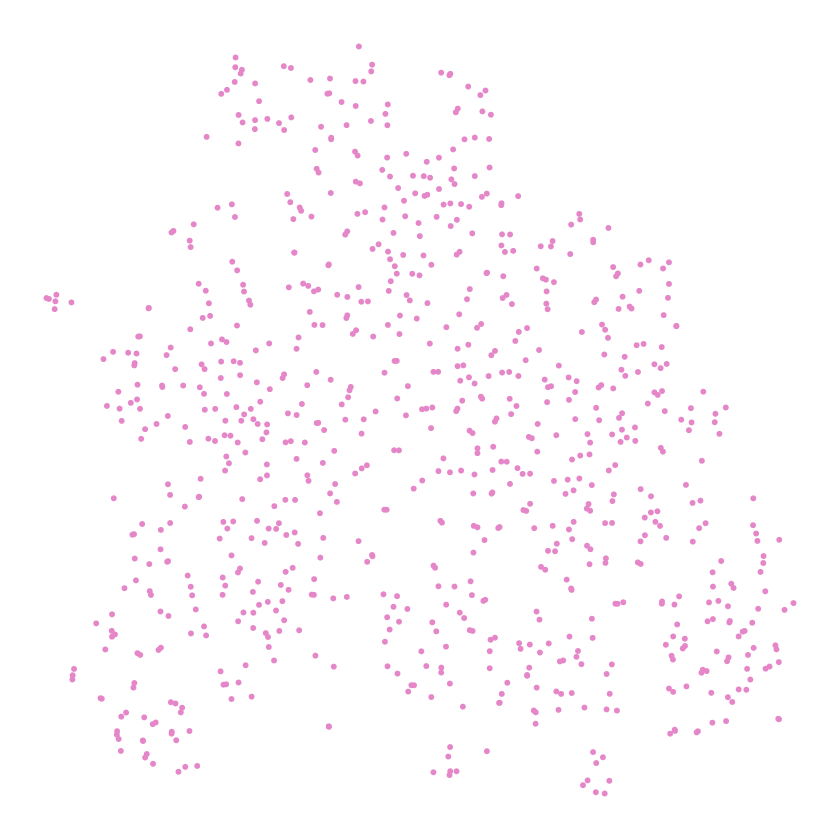

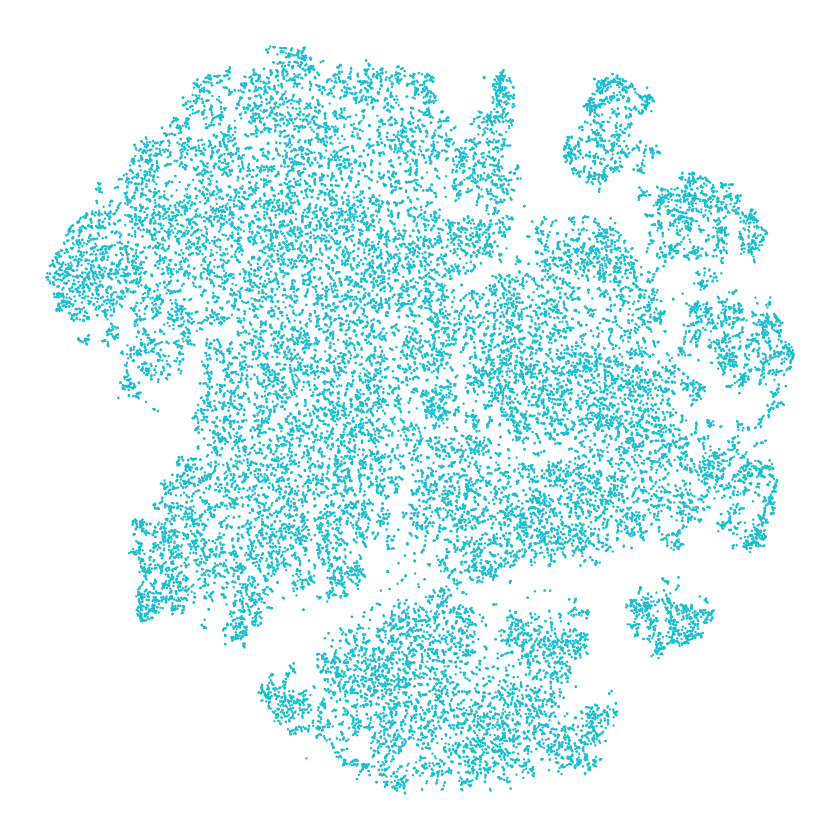

In [42]:
options(repr.plot.width = 7, repr.plot.height = 7)
# for (filename in Sys.glob("~/FGID13/T1*")) {
#     srobj.celltype = readRDS(filename)
#     srobj.celltype@meta.data = FGID13@meta.data[colnames(srobj.celltype), ]
#     srobj.celltype = srobj.celltype[, !srobj.celltype$is_doublet]
#     srobj.celltype <- RunTSNE(srobj.celltype, 
#              initialization = srobj.celltype@reductions$pca@cell.embeddings[, 1:2],
#              perplexity_list = c(30, ncol(srobj.celltype)/100),
#              learning_rate = ncol(srobj.celltype)/12,
#              exaggeration = 12,
#              dims = srobj.celltype@misc$nPCs,
#              tsne.method = "FIt-SNE")

#     celltype = as.character(srobj.celltype$celltypes[1])
#     saveRDS(srobj.celltype, file.path(nodoublet_dir, sprintf("%s_srobj.rds", celltype)))
for (filename in Sys.glob("~/FGID13/srobjs_doubletsremoved/*")) {
    
    srobj.celltype = readRDS(filename)
    p = DimPlot(srobj.celltype, group.by="celltypes", cols=celltype_colors) +
        theme_void() +
        theme(legend.position="bottom")
    L = get_legend(p)
    
    celltype = gsub("_sr.*", "", basename(filename))
    
    print(celltype)
    print(p + NoLegend())
    
    
#     print(as_ggplot(L))
    
    ggsave(plot = p + NoLegend(), 
           file=file.path(FIGDIR, sprintf("%s_FGID_cellsubsets_tsne_points.pdf", celltype)),
           height=8, width=8,
           useDingbats=FALSE)
#     ggsave(plot = as_ggplot(L),
#            file=file.path(FIGDIR, sprintf("20200402_%s_FGID_cellsubsets_tsne_legend.pdf", celltype)),
#            useDingbats=FALSE)
}

# Cell subset tsne (color by tierNname)

In [1]:
Sys.glob("~/FGID13/srobjs_doubletsremoved/*")

[1] "/home/jupyter-user/FGID13/srobjs_doubletsremoved/Bclls_srobj.rds"         
 [2] "/home/jupyter-user/FGID13/srobjs_doubletsremoved/Endth_srobj.rds"         
 [3] "/home/jupyter-user/FGID13/srobjs_doubletsremoved/Epith_srobj.rds"         
 [4] "/home/jupyter-user/FGID13/srobjs_doubletsremoved/Fibro_srobj.rds"         
 [5] "/home/jupyter-user/FGID13/srobjs_doubletsremoved/Glial_srobj.rds"         
 [6] "/home/jupyter-user/FGID13/srobjs_doubletsremoved/IGA_IGK_Plsma_srobj.rds" 
 [7] "/home/jupyter-user/FGID13/srobjs_doubletsremoved/IGA_IGL_Plsma_srobj.rds" 
 [8] "/home/jupyter-user/FGID13/srobjs_doubletsremoved/IGG_Plsma_Bcll_srobj.rds"
 [9] "/home/jupyter-user/FGID13/srobjs_doubletsremoved/IGM_Plsma_srobj.rds"     
[10] "/home/jupyter-user/FGID13/srobjs_doubletsremoved/Mloid_srobj.rds"         
[11] "/home/jupyter-user/FGID13/srobjs_doubletsremoved/Mstcl_srobj.rds"         
[12] "/home/jupyter-user/FGID13/srobjs_doubletsremoved/Tclls_srobj.rds"

[1] "Bclls"


Saving 6.67 x 6.67 in image



[1] "Endth"


Saving 6.67 x 6.67 in image



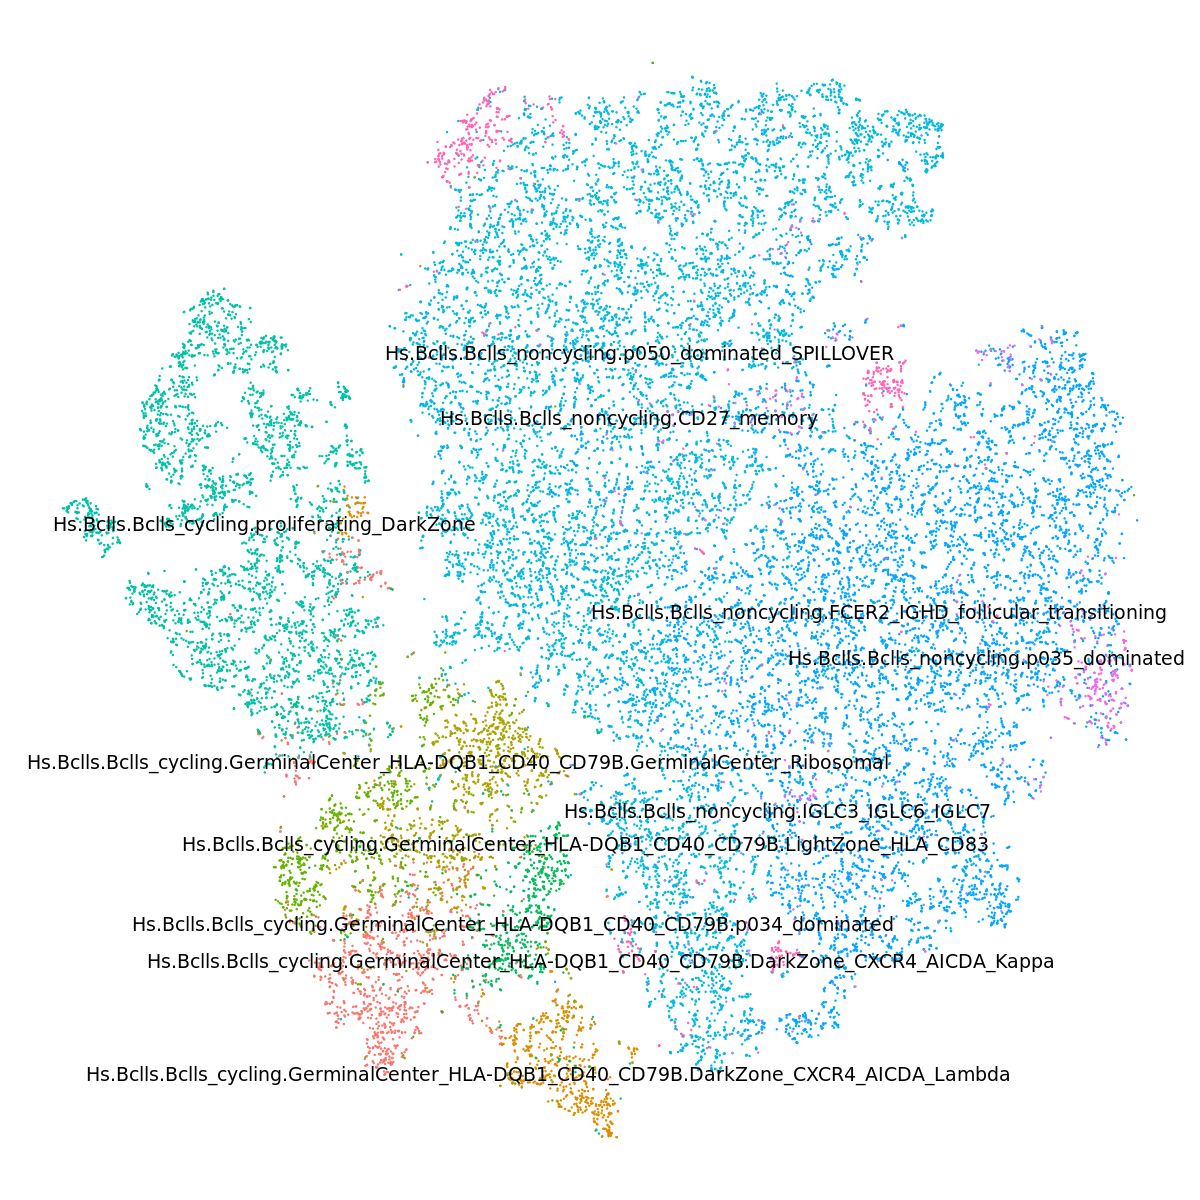

[1] "Epith"


Saving 6.67 x 6.67 in image



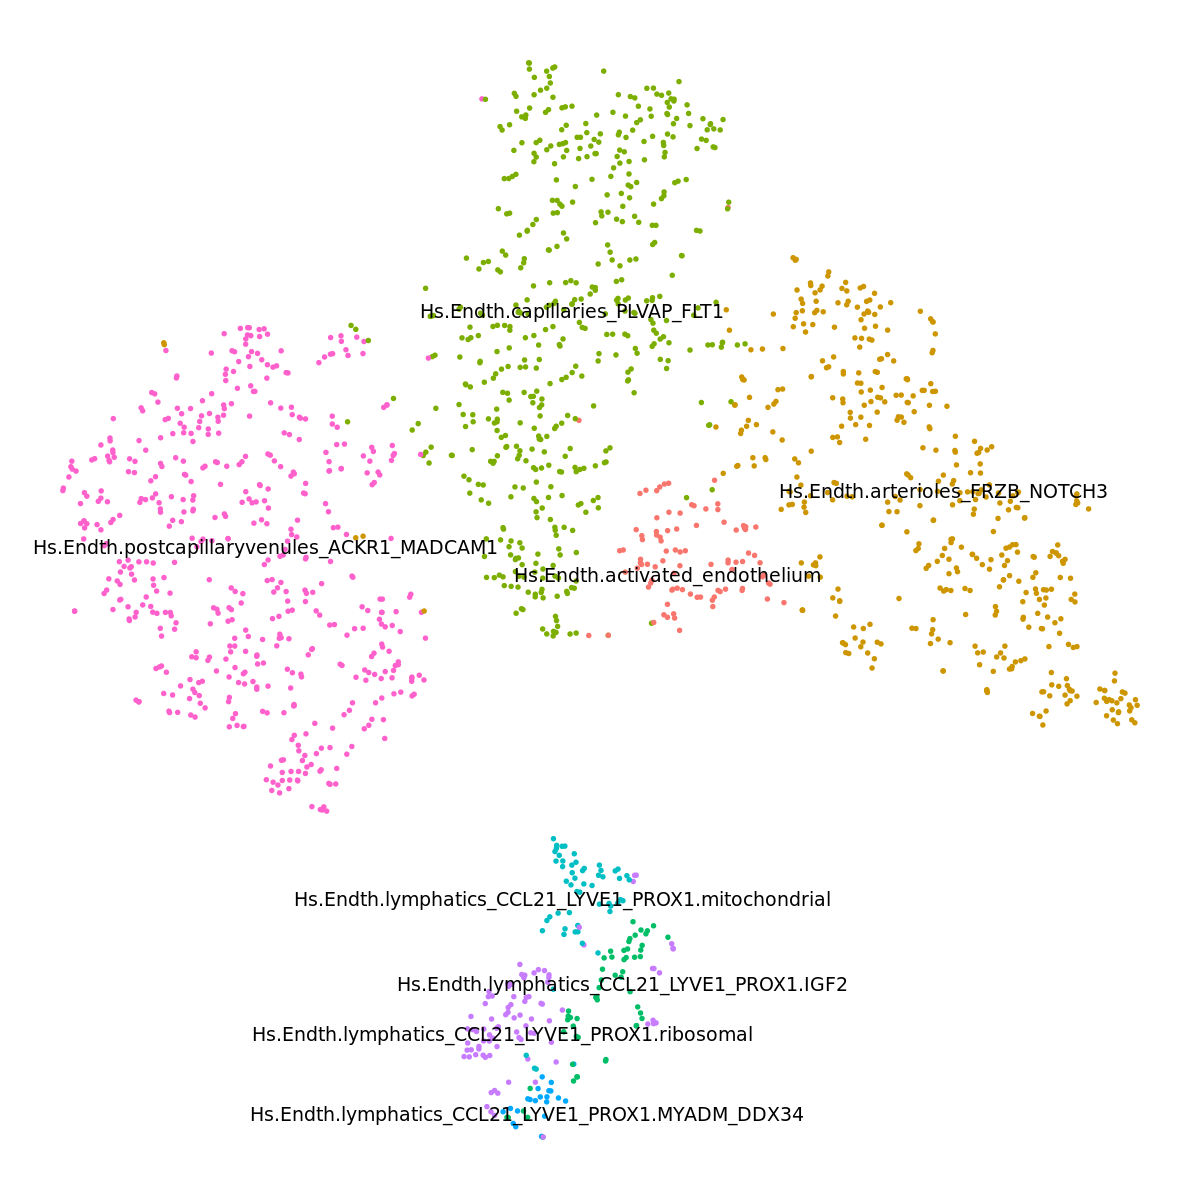

[1] "Fibro"


Saving 6.67 x 6.67 in image



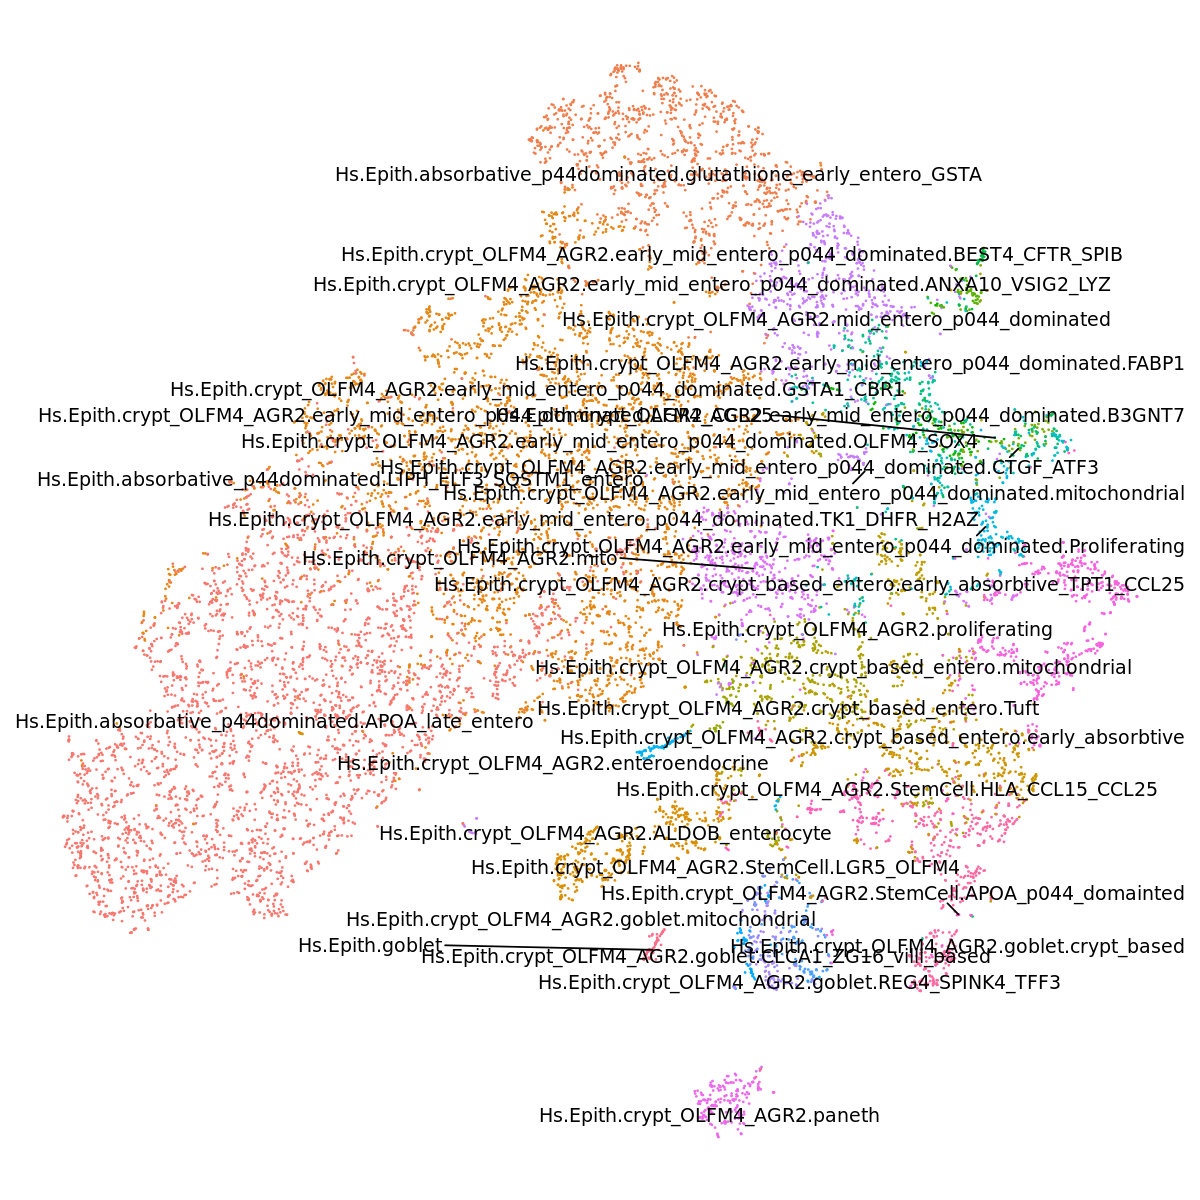

[1] "Glial"


Saving 6.67 x 6.67 in image



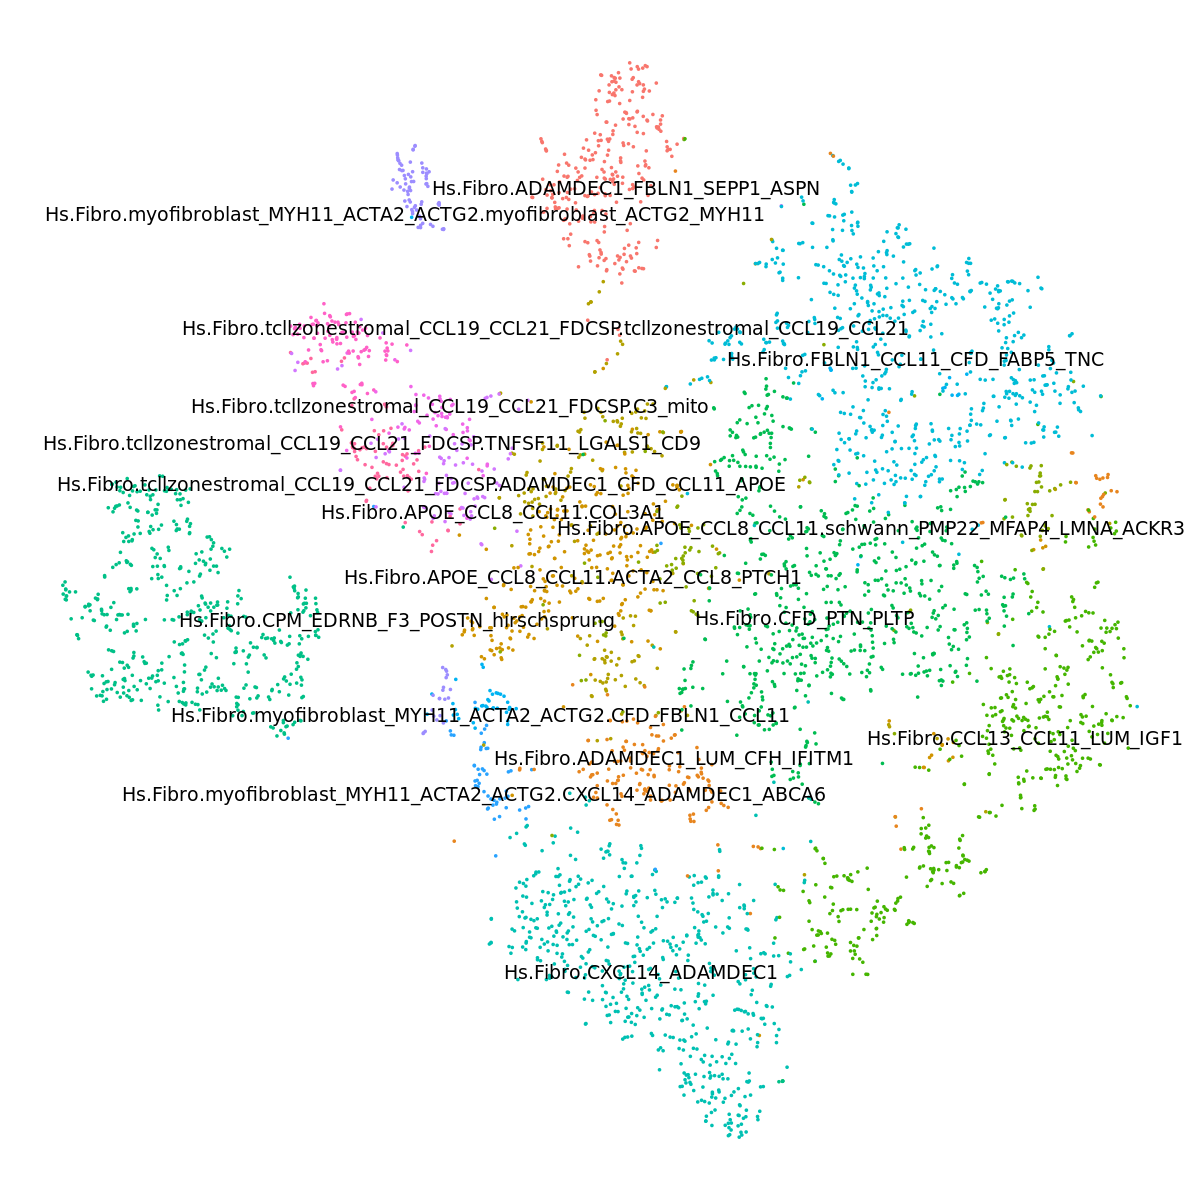

[1] "IGA_IGK_Plsma"


Saving 6.67 x 6.67 in image



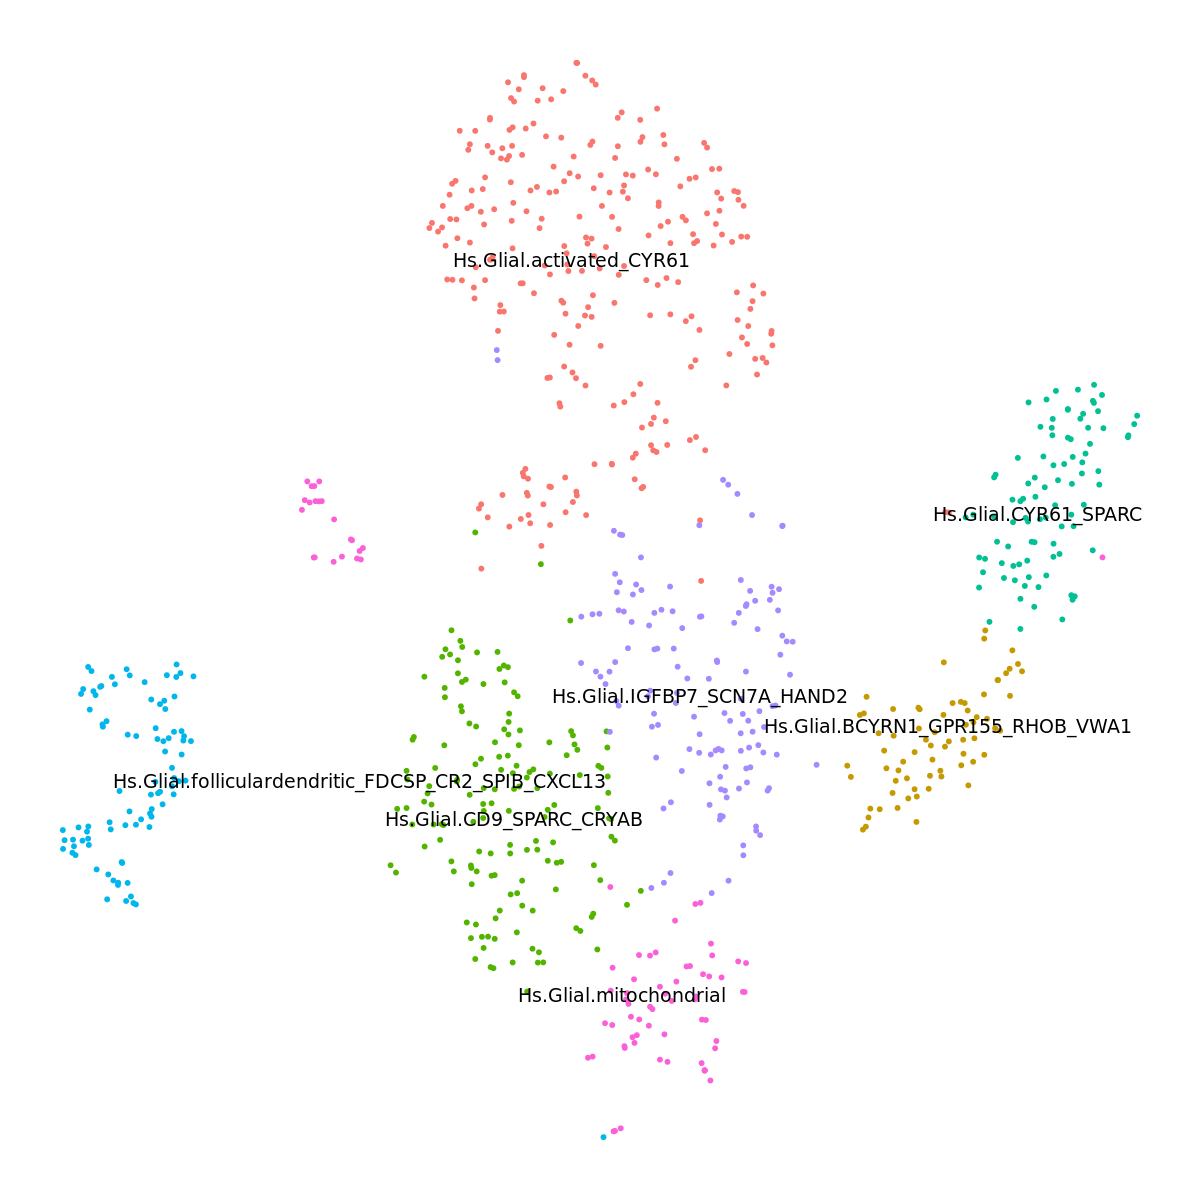

[1] "IGA_IGL_Plsma"


Saving 6.67 x 6.67 in image



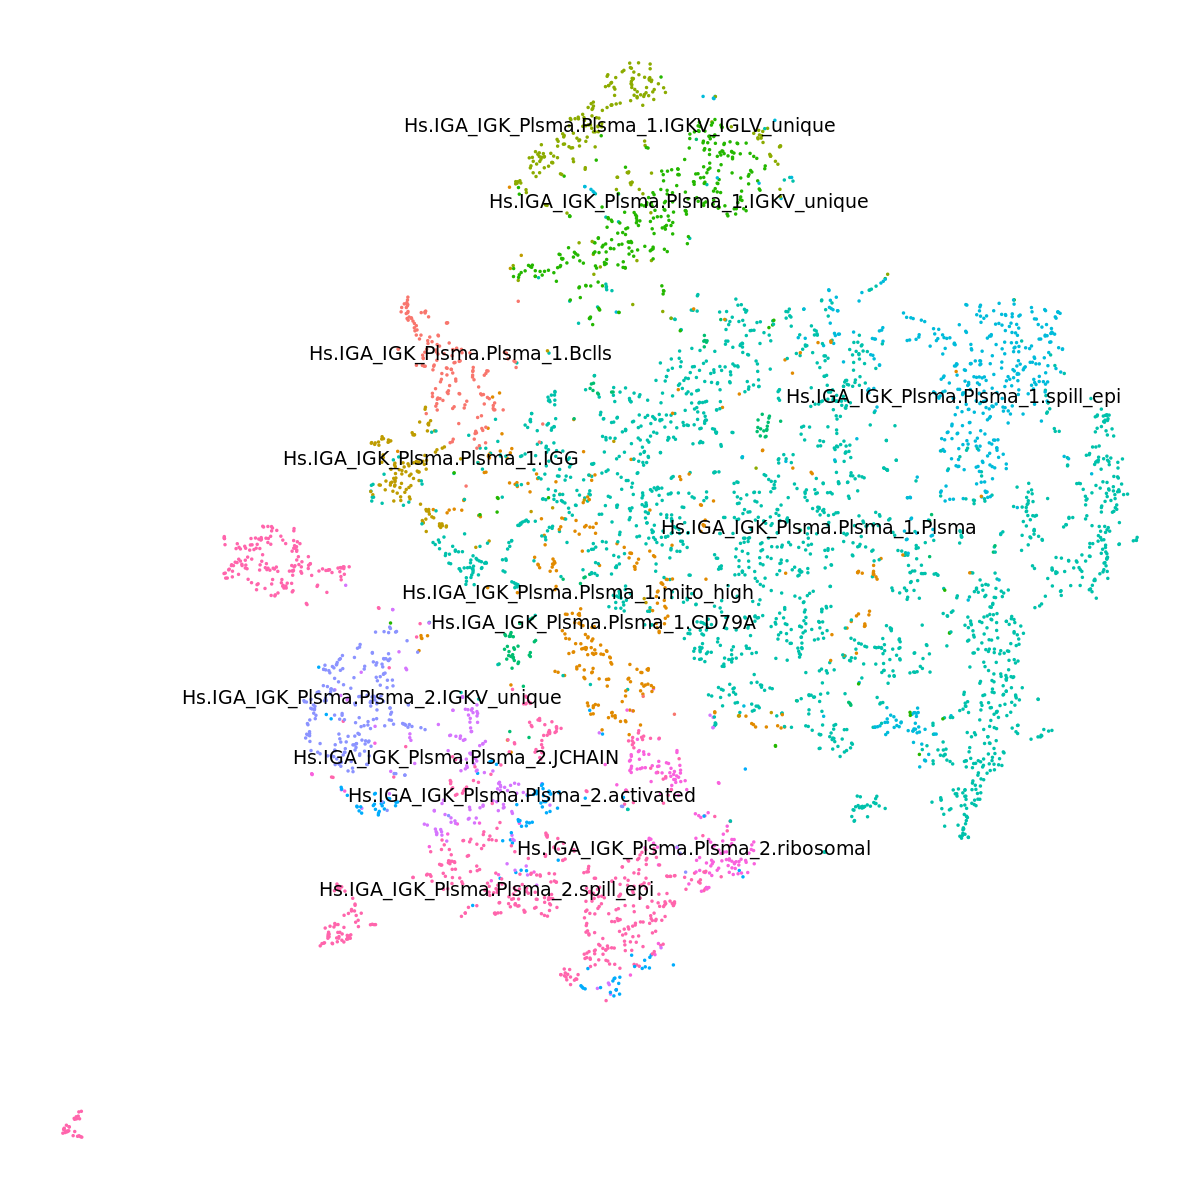

[1] "IGG_Plsma_Bcll"


Saving 6.67 x 6.67 in image



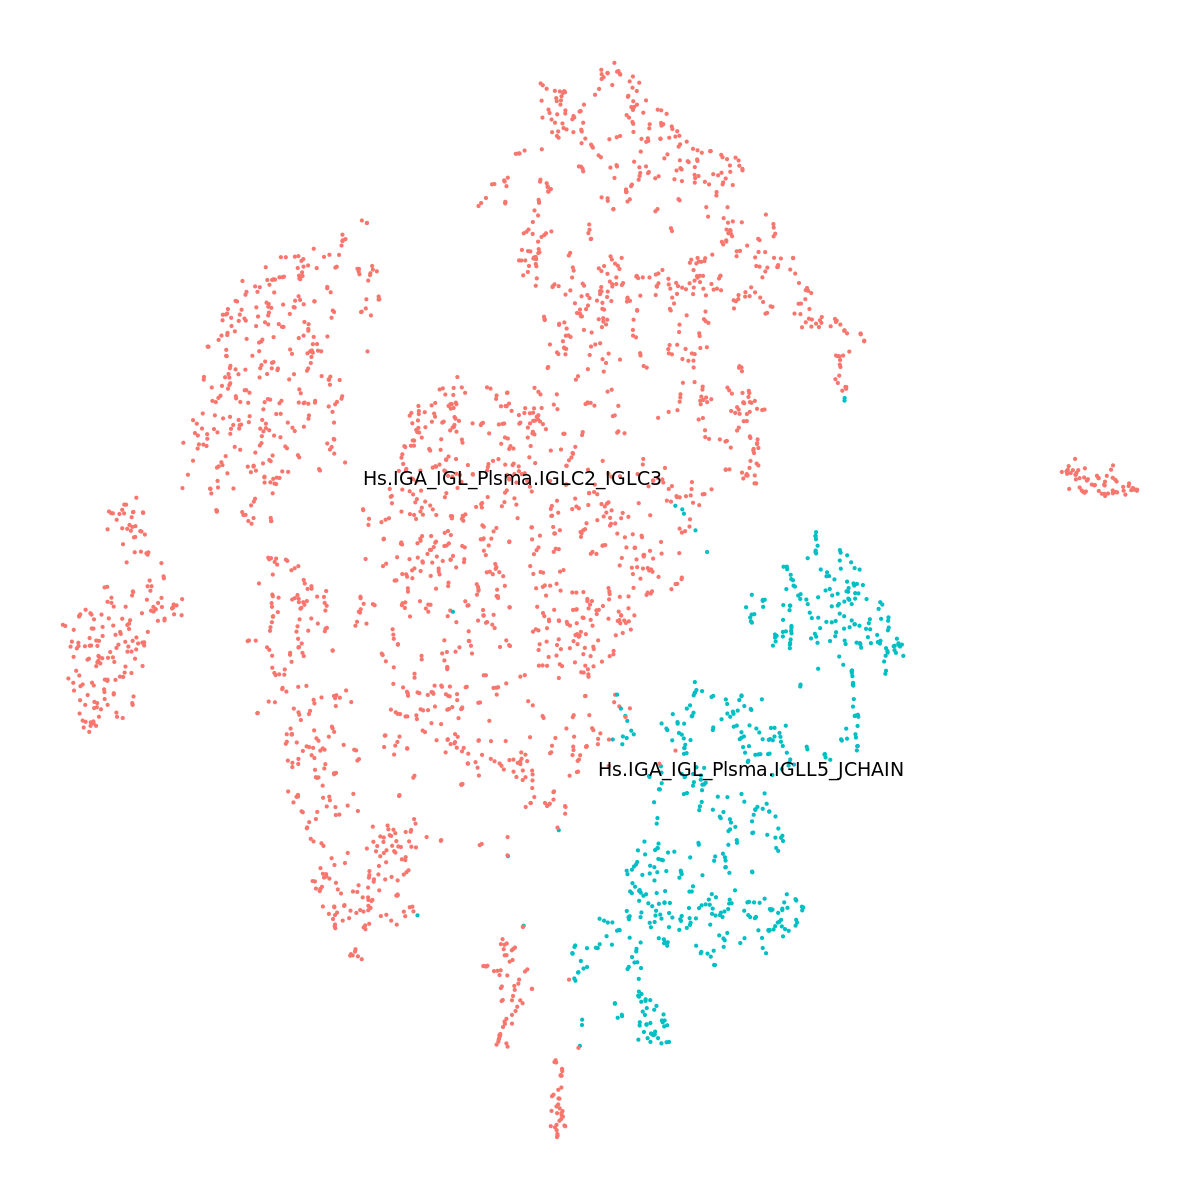

[1] "IGM_Plsma"


Saving 6.67 x 6.67 in image



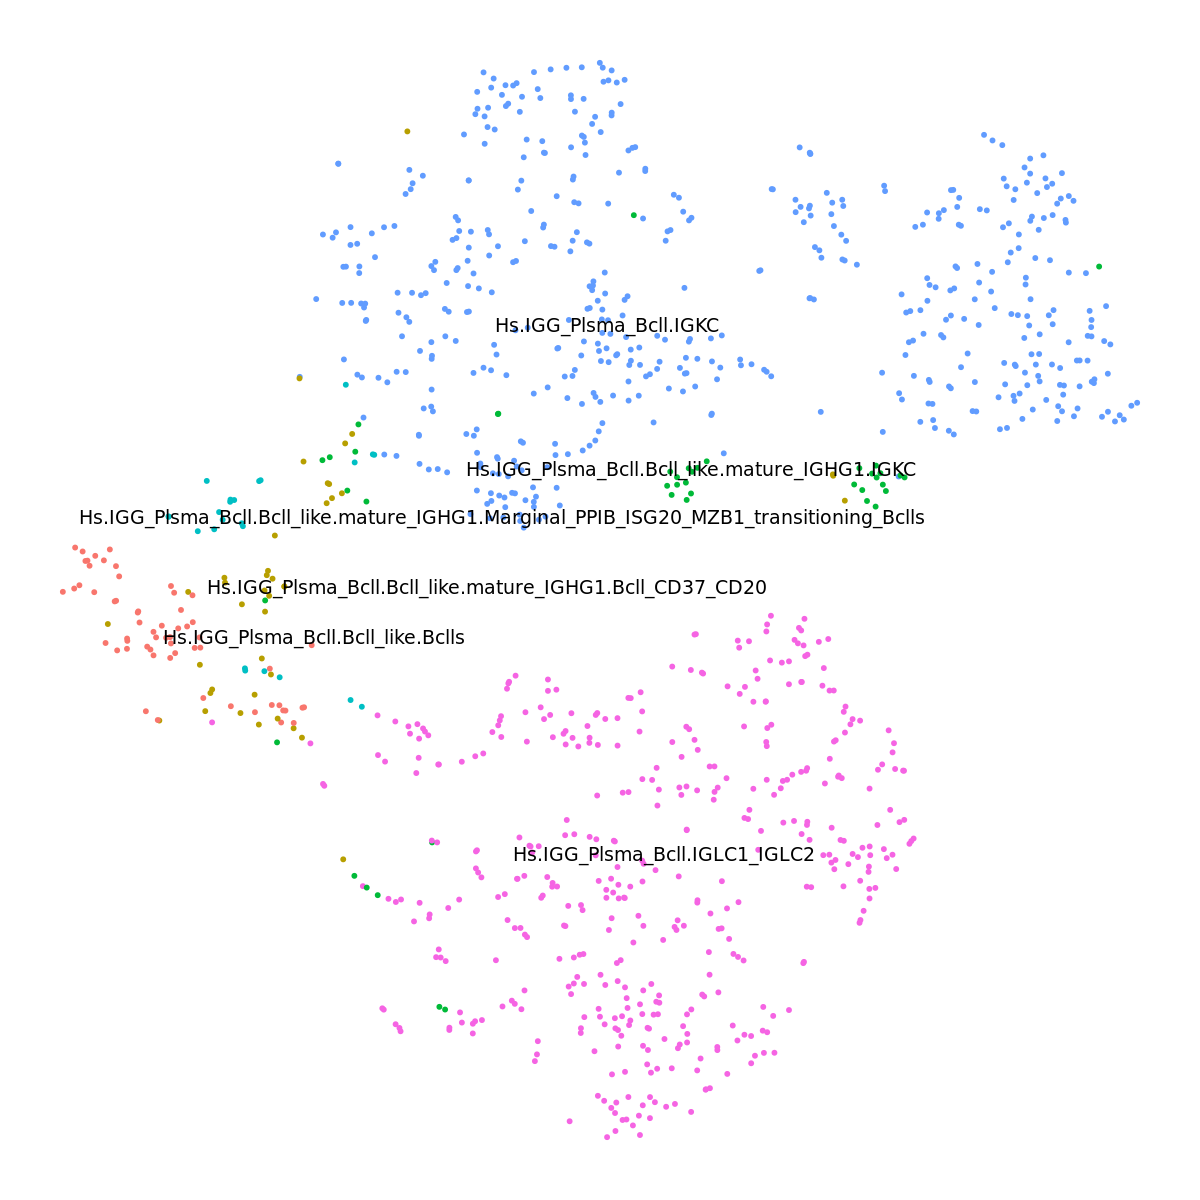

[1] "Mloid"


Saving 6.67 x 6.67 in image



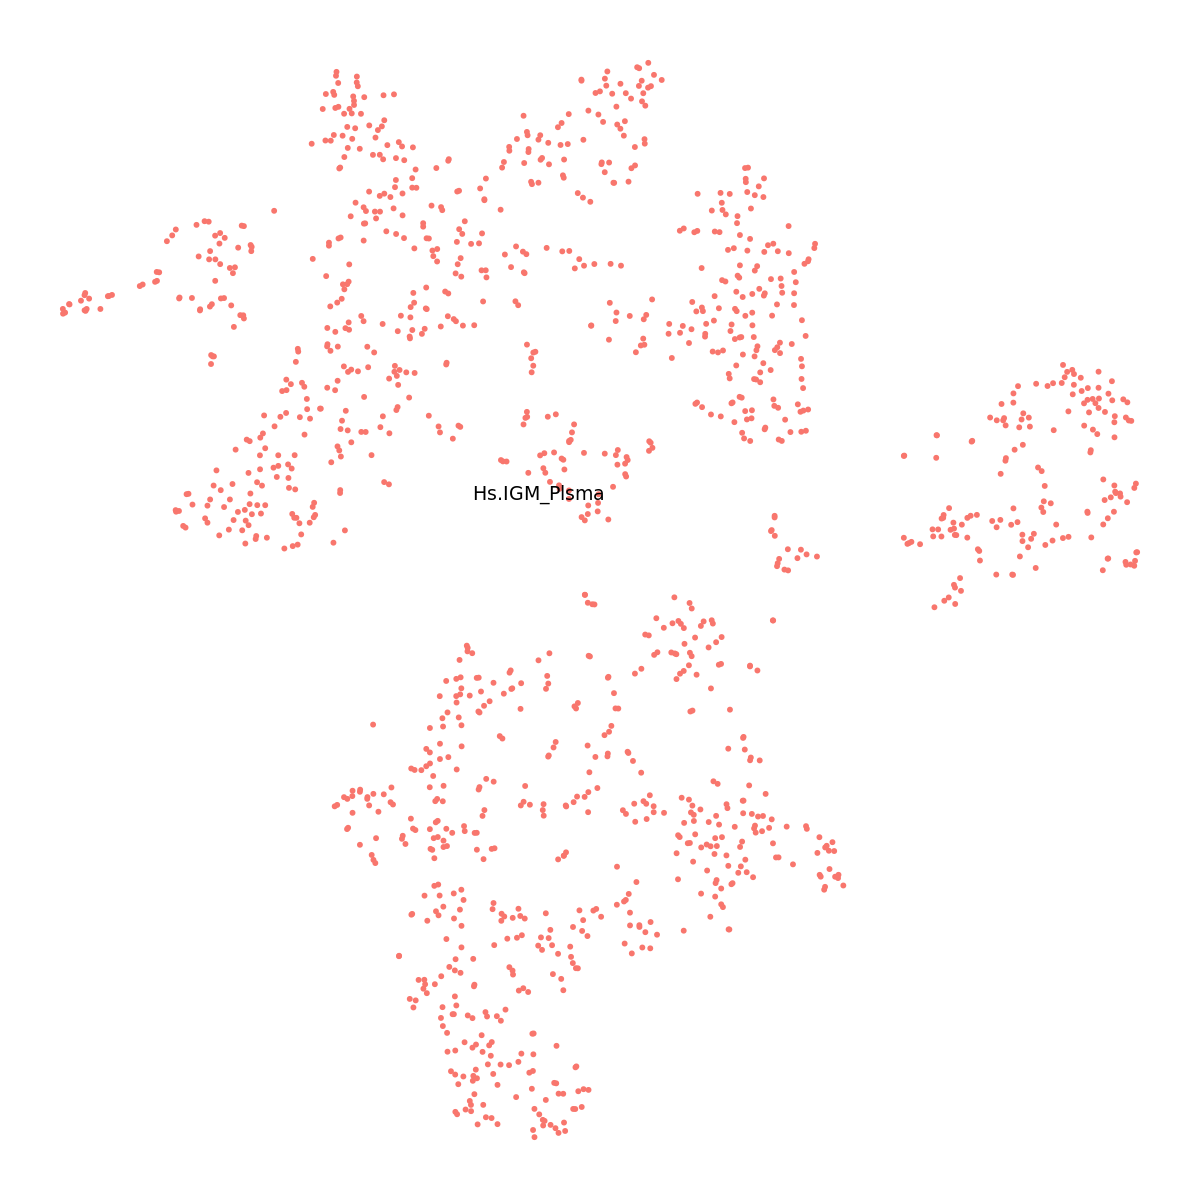

[1] "Mstcl"


Saving 6.67 x 6.67 in image



In [ ]:
options(repr.plot.width = 10, repr.plot.height = 10)
fgid_meta = read.table("~/FGID13/20200422_clmeta_FGID13_all.tsv", header=1) %>% column_to_rownames("CellID")
# for (filename in Sys.glob("~/FGID13/T1*")) {
#     srobj.ctp = readRDS(filename)
#     srobj.ctp@meta.data = FGID13@meta.data[colnames(srobj.ctp), ]
#     srobj.ctp = srobj.ctp[, !srobj.ctp$is_doublet]
#     srobj.ctp <- RunTSNE(srobj.ctp, 
#              initialization = srobj.ctp@reductions$pca@cell.embeddings[, 1:2],
#              perplexity_list = c(30, ncol(srobj.ctp)/100),
#              learning_rate = ncol(srobj.ctp)/12,
#              exaggeration = 12,
#              dims = srobj.ctp@misc$nPCs,
#              tsne.method = "FIt-SNE")

#     ctp = as.character(srobj.ctp$ctps[1])
#     saveRDS(srobj.ctp, file.path(nodoublet_dir, sprintf("%s_srobj.rds", ctp)))
for (filename in Sys.glob("~/FGID13/srobjs_doubletsremoved/*")) {
    
    srobj.ctp = readRDS(filename)
    srobj.ctp@meta.data = fgid_meta[colnames(srobj.ctp), ]
    p = DimPlot(srobj.ctp, group.by="tierNname", 
                label=TRUE, repel=TRUE, label.size=4) +
        theme_void() +
        theme(legend.position="bottom")
    L = get_legend(p)
    
    ctp = gsub("_sr.*", "", basename(filename))
    
    print(ctp)
    print(p + NoLegend())
    
    
#     print(as_ggplot(L))
    
    ggsave(plot = p + NoLegend(), 
           file=file.path(FIGDIR, sprintf("20200619_%s_FGID_tsne_tierNname.pdf", ctp)),
           height=10, width=10,
           useDingbats=FALSE)
    ggsave(plot = as_ggplot(L),
           file=file.path(FIGDIR, sprintf("20200619_%s_FGID_tsne_tierNname_legend.pdf", ctp)),
           useDingbats=FALSE)
}

# Sync

In [8]:
system(sprinf("gsutil -m rsync -r %s %s", Sys.getenv("FIGDIR"), Sys.getenv("FIG_BUCKET")))